In [66]:
#!pip install yfinance
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

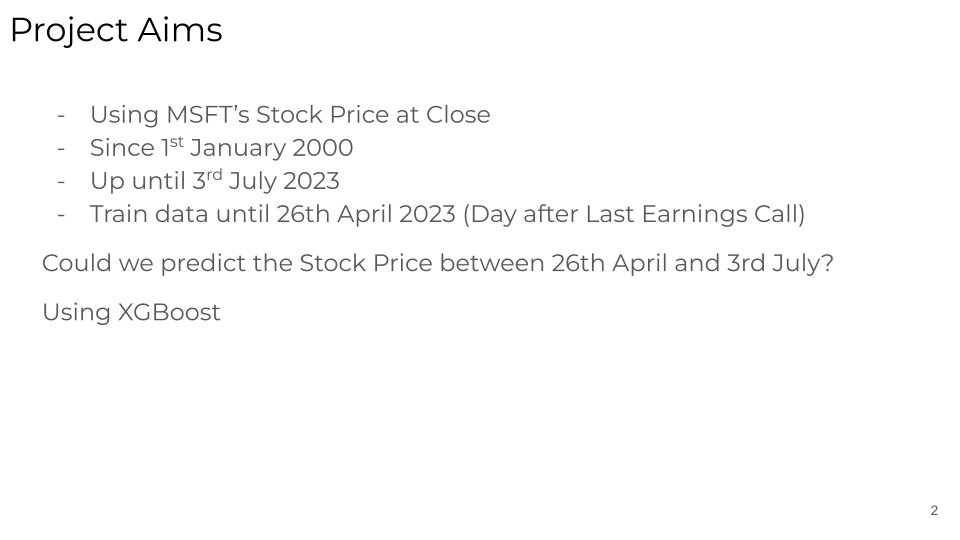

In [67]:
# Loaded the start date - This is the date from when the data will be uploaded - 1st Jan 2000
start_date = '2000-01-01'
start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')

# We will train the model up until the 3rd of July, and then predict on the 10th of July

# The end_date is the last day for which we will load training data - 3rd July 2023
end_date = '2023-07-03'
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')

# The target date is the date for which we want to predict the stock price - 10th July 2023
target_date = '2023-07-10'
target_date_dt = datetime.strptime(target_date, '%Y-%m-%d')

### Loading MSFT Data up until 10th July

In [68]:
# Choose the ticker symbol
tickerSymbol = 'MSFT'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
# We want to load the data up until the 10th July - we will restrict the dataframe to the 3rd July later
msft = tickerData.history(period='1d', start= start_date_dt, end= (target_date_dt + timedelta(days = 1))) #We need to add 1 day to the end of the range so that the time range goes up to the desired target date

# Visualise
msft

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-05:00,36.316966,36.703728,34.653889,36.065571,53228400,0.0,0.0
2000-01-04 00:00:00-05:00,35.137335,36.239607,34.731235,34.847263,54119000,0.0,0.0
2000-01-05 00:00:00-05:00,34.383164,36.007565,33.841697,35.214703,64059600,0.0,0.0
2000-01-06 00:00:00-05:00,34.711902,35.234031,33.532278,34.035069,54976600,0.0,0.0
2000-01-07 00:00:00-05:00,33.609628,34.731239,33.203528,34.479843,62013600,0.0,0.0
...,...,...,...,...,...,...,...
2023-07-03 00:00:00-04:00,337.164281,338.864060,334.559933,335.971436,12508700,0.0,0.0
2023-07-05 00:00:00-04:00,333.088740,339.609560,332.730905,336.130463,18172400,0.0,0.0
2023-07-06 00:00:00-04:00,335.285551,340.941571,333.496313,339.231842,28161200,0.0,0.0


In [69]:
# Let's isolate the column with the closing price, as we will not be using be using any of the other columns in this data frame
msft = msft[['Close']]

# Resetting the date index so that we can manipulate the daytime object to contain a year-month-day formatted date
# msft = msft.reset_index()
# msft['Date'] = msft['Date'].dt.date
# msft = msft.set_index('Date')

# Send the Close column is what we are going to use as an indicator for the price, we can rename it for greater clarity
msft = msft.rename(columns = {'Close': 'Price'})
msft

,Price
Date,
2000-01-03 00:00:00-05:00,36.065571
2000-01-04 00:00:00-05:00,34.847263
2000-01-05 00:00:00-05:00,35.214703
2000-01-06 00:00:00-05:00,34.035069
2000-01-07 00:00:00-05:00,34.479843
...,...
2023-07-03 00:00:00-04:00,335.971436
2023-07-05 00:00:00-04:00,336.130463
2023-07-06 00:00:00-04:00,339.231842


In [70]:
msft.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5916 entries, 2000-01-03 00:00:00-05:00 to 2023-07-10 00:00:00-04:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   5916 non-null   float64
dtypes: float64(1)
memory usage: 92.4 KB


Now, let's restrict the data frame to the last day of trading that we will feed into our model, eg the `end_date` of the 3rd July 2023



In [71]:
# Then, restrict the df
df = msft[:end_date]

# Remove the timezone information and set the time to midnight
df.index = df.index.tz_convert(None).normalize()

df

,Price
Date,
2000-01-03,36.065571
2000-01-04,34.847263
2000-01-05,35.214703
2000-01-06,34.035069
2000-01-07,34.479843
...,...
2023-06-27,332.571899
2023-06-28,333.844238
2023-06-29,333.049011


In [72]:
df['Price'].iloc[0:3]

Date
2000-01-03    36.065571
2000-01-04    34.847263
2000-01-05    35.214703
Name: Price, dtype: float64

# Initialise randomised sampling to create an input and output array

In [73]:
# Initialize lists to store input and output sequences
input_sequences = []
output_sequences = []

In [74]:
# Define the sequence length (12 for input, 13 for output)
sequence_length = 91

In [75]:
# Iterate through the data to create sequences
for i in range(len(df['Price']) - sequence_length - 1): #Iterate through the first 5820 (=5912-91-1) rows
    input_seq = df['Price'].iloc[i:i + sequence_length]  # Get (the rolling) 91 rows from the Price column and add them to a Pandas Series called `input seq`.
    output_seq = df['Price'].iloc[i + sequence_length]  # Get the corresponding 92nd output value and add it to a Pandas Series called `output_seq`
    input_sequences.append(list(input_seq))
    output_sequences.append(output_seq)
    last = i

In [76]:
print(i)

5819


In [77]:
# Convert the lists to NumPy arrays
input_sequences = np.array(input_sequences)
output_sequences = np.array(output_sequences)

In [78]:
print(len(input_sequences))

5820


In [79]:
print(len(output_sequences))

5820


## Separate the input & output sequences into Training and Testing - Change % Training and Testing

In [80]:
# Pick the % of the dataset that we want to set aside for testing
pct_testing = 20

# Convert it into an index location in the input array for slicing
slicing_index = len(input_sequences) * pct_testing/100  #this makes a float so it needs to be casted onto an `int`
slicing_index = int(slicing_index)


# Slice the input and output sequences to separate training and test data
X_train = input_sequences[:-slicing_index]
y_train = output_sequences[:-slicing_index]
X_test = input_sequences[-slicing_index:]
y_test = output_sequences[-slicing_index:]

### What this is doing:
![](https://drive.google.com/uc?export=view&id=1DmAs743q67xDinxbiVE_DLVZn61IjtLo)

In [81]:
print('X_train has shape ', X_train.shape, ' and its data is', X_train)
print('y_train has shape ', y_train.shape, ' and its data is', y_train)
print('X_test has shape ', X_test.shape, ' and its data is', X_test)
print('y_test has shape ', y_test.shape, ' and its data is', y_test)

X_train has shape  (4656, 91)  and its data is [[ 36.06557083  34.84726334  35.21470261 ...  20.98184204  20.4790535
   21.00119209]
 [ 34.84726334  35.21470261  34.03506851 ...  20.4790535   21.00119209
   21.29125786]
 [ 35.21470261  34.03506851  34.47984314 ...  21.00119209  21.29125786
   21.46530151]
 ...
 [ 94.02432251  93.12178802  93.78928375 ... 101.46443176 101.6625824
  105.66416931]
 [ 93.12178802  93.78928375  95.1055069  ... 101.6625824  105.66416931
  105.46599579]
 [ 93.78928375  95.1055069   95.7542038  ... 105.66416931 105.46599579
  103.40856934]]
y_train has shape  (4656,)  and its data is [ 21.29125786  21.46530151  21.50396729 ... 105.46599579 103.40856934
 100.86042023]
X_test has shape  (1164, 91)  and its data is [[ 95.1055069   95.7542038   96.00804138 ... 105.46599579 103.40856934
  100.86042023]
 [ 95.7542038   96.00804138  95.87643433 ... 103.40856934 100.86042023
  100.92648315]
 [ 96.00804138  95.87643433  97.9541626  ... 100.86042023 100.92648315
   99.4

# Create MLP Regressor Model

## Create a Preliminary Model and Observe Performance

In [82]:
from sklearn.neural_network import MLPRegressor

In [83]:
model1 = MLPRegressor()

In [84]:
model1.fit(X_train, y_train)

MLPRegressor()

In [85]:
y_pred1 = model1.predict(X_test)

In [86]:
print(y_pred1)
print(y_pred1.shape)

[ 98.92644673  99.66351772  98.99453541 ... 326.83653062 324.85085788
 323.38255979]
(1164,)


In [87]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate Mean Squared Error (MSE)
mse_1 = mean_squared_error(y_test, y_pred1)

# Calculate Mean Absolute Error (MAE)
mae_1 = mean_absolute_error(y_test, y_pred1)

# Calculate RMSE
rmse_1 = np.sqrt(mse_1)

# Calculate R-squared (R2) score
r2_1 = r2_score(y_test, y_pred1)

# Print the results
print(f"Mean Squared Error (MSE): {mse_1}")
print(f"Mean Absolute Error (MAE): {mae_1}")
print(f"RMSE: {rmse_1}")
print(f"R-squared (R2) Score: {r2_1}")


Mean Squared Error (MSE): 73.35803703746824
Mean Absolute Error (MAE): 6.8870411815452055
RMSE: 8.564930649892515
R-squared (R2) Score: 0.9842852734808639


### Compare model predictions with `y_test`

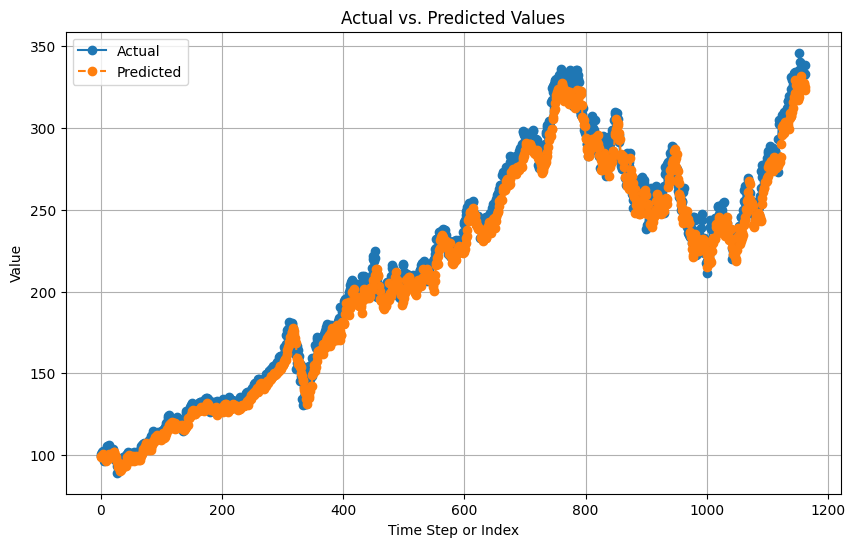

In [88]:
# Create an array for the x-axis (indices or time steps)
x = np.arange(len(y_test))

# Create a line plot for y_pred and y_test
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(x, y_test, label='Actual', marker='o', linestyle='-')
plt.plot(x, y_pred1, label='Predicted', marker='o', linestyle='--')

# Add labels and a legend
plt.xlabel('Time Step or Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()


In [89]:
score = np.sqrt(mean_squared_error(y_test, y_pred1))
print(f'RMSE Score on Test set: {score:0.2f}')
print(f'R^2 Score on Test set: {r2_1:0.2f}')

RMSE Score on Test set: 8.56
R^2 Score on Test set: 0.98


# Cross-Validation of Regressor Parameters

In [90]:
df = df.astype(float)

In [91]:
from sklearn.preprocessing import StandardScaler
# Use StandardScaler to scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)  # Scaling the  data


In [92]:
df_scaled.shape

(5912, 1)

In [93]:
df.shape

(5912, 1)

In [94]:
# Initialize lists to store input and output sequences
input_sequences_scaled = []
output_sequences_scaled = []

# Define the sequence length (12 for input, 13 for output)
sequence_length = 91

# Iterate through the data to create sequences
for i in range(len(df_scaled) - sequence_length - 1): #Iterate through the first 5899 rowss and leave the last 13 rows alone
    input_seq = df_scaled[i:i + sequence_length]  # Get (the rolling) 12 rows from the Price column and add them to a Pandas Series called `input seq`.
    output_seq = df_scaled[i + sequence_length]  # Get the corresponding 13th output value and add it to a Pandas Series called `output_seq`
    input_sequences_scaled.append(list(input_seq))
    output_sequences_scaled.append(output_seq)

# Convert the lists to NumPy arrays
input_sequences_scaled = np.array(input_sequences_scaled)
output_sequences_scaled = np.array(output_sequences_scaled)

# Pick the % of the dataset that we want to set aside for testing
pct_testing = 20

# Convert it into an index location in the input array for slicing
slicing_index = len(input_sequences_scaled) * pct_testing/100  #this makes a float so it needs to be casted onto an `int`
slicing_index = int(slicing_index)


# Slice the input and output sequences to separate training and test data
X_train_cv = input_sequences_scaled[:-slicing_index]
y_train_cv = output_sequences_scaled[:-slicing_index]
X_test_cv = input_sequences_scaled[-slicing_index:]
y_test_cv = output_sequences_scaled[-slicing_index:]

In [95]:
# Check the dimensions of X_train
X_train_cv.shape

(4656, 91, 1)

In [96]:
# It needs to be a 2D numpy array for sklearns's MLP Regressor. Therefore, we need to flatten it.
# Flatten X_train
X_train_cv = X_train_cv.reshape((X_train_cv.shape[0], -1))  # Reshape to (4720, 12 * 1)
X_test_cv = X_test_cv.reshape((X_test_cv.shape[0], -1))

In [97]:
# Check the dimensions of X_train
X_train_cv.shape

(4656, 91)

In [98]:
X_train_cv

array([[-0.3674966 , -0.38235291, -0.37787228, ..., -0.55143098,
        -0.5575621 , -0.55119503],
       [-0.38235291, -0.37787228, -0.392257  , ..., -0.5575621 ,
        -0.55119503, -0.5476579 ],
       [-0.37787228, -0.392257  , -0.38683332, ..., -0.55119503,
        -0.5476579 , -0.54553557],
       ...,
       [ 0.33926548,  0.32825977,  0.33639936, ...,  0.42999185,
         0.43240814,  0.48120439],
       [ 0.32825977,  0.33639936,  0.35244968, ...,  0.43240814,
         0.48120439,  0.47878782],
       [ 0.33639936,  0.35244968,  0.36036004, ...,  0.48120439,
         0.47878782,  0.4536991 ]])

In [99]:
# Check the dimensions of y_train
y_train_cv.shape

(4656, 1)

In [100]:
# It needs to be a 1D numpy array for sklearns's MLP Regressor. Therefore, we need to flatten it.
# Flatten y_train
y_train_cv = y_train_cv.ravel()
y_test_cv = y_test_cv.ravel()

In [101]:
# Check the dimensions of y_train
y_train_cv.shape

(4656,)

In [102]:
param_grid = {'max_iter': [12, 15, 17, 20, 22, 24, 26],
              'hidden_layer_sizes': [(18,),(20,),(22,),(24,),(26,),(28,),(30,)]}

In [103]:
# %%time
# regressor = GridSearchCV(
#     estimator = MLPRegressor(),
#     param_grid = param_grid,
#     n_jobs = 4,
#     error_score='raise'
# )
# regressor.fit(X_train, y_train) #X_train and y_train have been scaled using StandardScaler
# print(regressor.best_score_)
# print(regressor.best_estimator_)

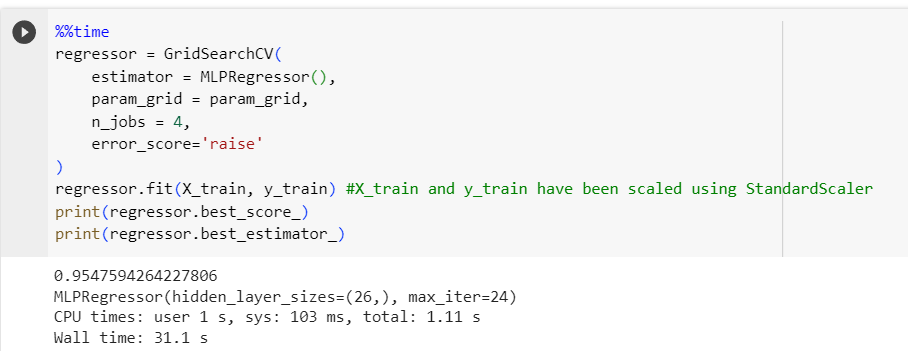

In [104]:
best_layer_size = (26,)
best_iter_max = 24

## Run MLP Regressor and create predictions on Scaled data.

In [105]:
%%time
model_cv = MLPRegressor(hidden_layer_sizes = best_layer_size,
                        max_iter = best_iter_max
                        )

model_cv.fit(X_train_cv, y_train_cv)
y_pred_cv = model_cv.predict(X_test_cv)
print(y_pred_cv)
print(y_pred_cv.shape)

[0.51419019 0.51101872 0.54759125 ... 1.44891593 1.43173274 1.43567214]
(1164,)
CPU times: user 495 ms, sys: 334 ms, total: 829 ms
Wall time: 445 ms


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(


In [106]:
# Calculate Mean Squared Error (MSE)
mse_2 = mean_squared_error(y_test_cv, y_pred_cv)

# Calculate Mean Absolute Error (MAE)
mae_2 = mean_absolute_error(y_test_cv, y_pred_cv)

# Calculate RMSE
rmse_2 = np.sqrt(mse_2)

# Calculate R-squared (R2) score
r2_2 = r2_score(y_test_cv, y_pred_cv)

# Print the results
print(f"Mean Squared Error (MSE): {mse_2}")
print(f"Mean Absolute Error (MAE): {mae_2}")
print(f"RMSE: {rmse_2}")
print(f"R-squared (R2) Score: {r2_2}")

Mean Squared Error (MSE): 0.5432675393159814
Mean Absolute Error (MAE): 0.5739801070255097
RMSE: 0.7370668486073576
R-squared (R2) Score: 0.21735565218461217


# Un-scale the predictions to see the 10th of July

In [107]:
trading_dates = msft[end_date:target_date].index.tz_convert(None).normalize()
trading_dates = trading_dates[1:] # Exclude the 3rd July 2023 because that's part of the Training Data
# trading_dates

# Extend the sequences up to the 10th of July
# First, copy each - 'input' and 'output'
extended_input_sequences = input_sequences.copy()  # Make a copy of the input sequences
extended_output_sequences = output_sequences.copy()  # Make a copy of the output sequences

for date in trading_dates:
    # Predict for the next day
    prediction = model_cv.predict(extended_input_sequences[-1].reshape(1, -1))  # Save the prediction for the last sequence in `prediction`
    print('For each date, we can print the `prediction` array ',prediction, 'and its shape, ', prediction.shape)
    extended_input_sequences_2 = np.vstack((extended_input_sequences, np.append(extended_input_sequences[-1, 1:], prediction)))
    extended_output_sequences_2 = np.append(extended_output_sequences, prediction)

# # Print or use the predictions for July 4th to July 10th
print("Predictions for July 10th:", extended_output_sequences[-1])

For each date, we can print the `prediction` array  [138.0360518] and its shape,  (1,)
For each date, we can print the `prediction` array  [138.0360518] and its shape,  (1,)
For each date, we can print the `prediction` array  [138.0360518] and its shape,  (1,)
For each date, we can print the `prediction` array  [138.0360518] and its shape,  (1,)
Predictions for July 10th: 338.5062255859375


***stuck here

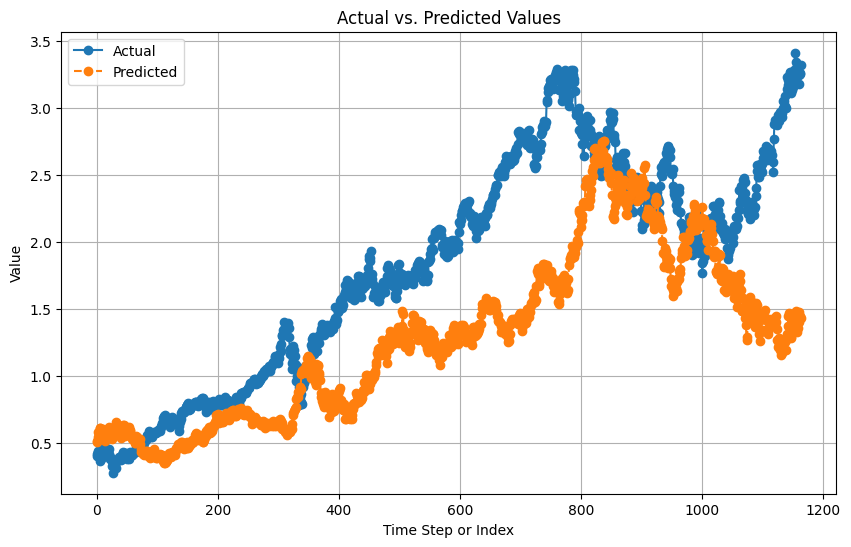

In [108]:
# Create an array for the x-axis (indices or time steps)
x = np.arange(len(y_test))

# Create a line plot for y_pred and y_test
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(x, y_test_cv, label='Actual', marker='o', linestyle='-')
plt.plot(x, y_pred_cv, label='Predicted', marker='o', linestyle='--')

# Add labels and a legend
plt.xlabel('Time Step or Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()

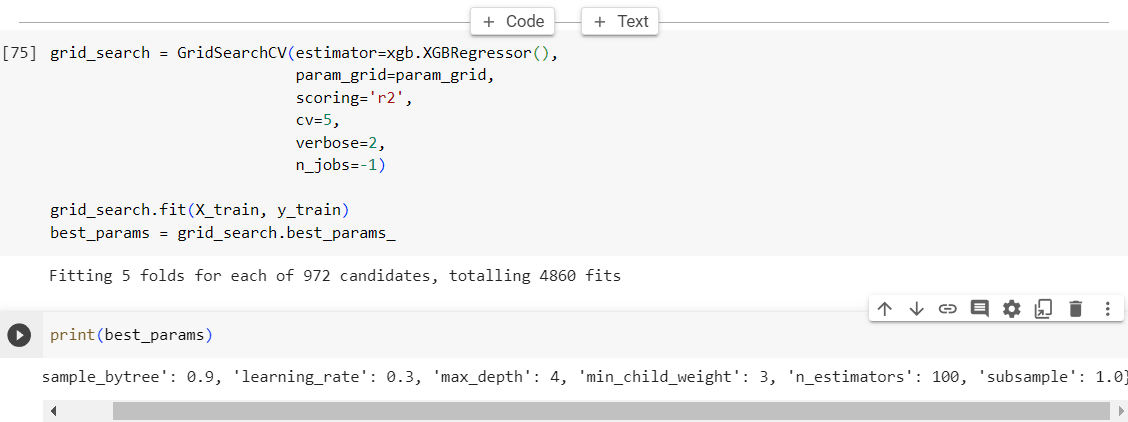

The output of this cell has been saved in a new variable `best_params_saved_1st`

In [109]:
best_params_saved_1st = {'colsample_bytree': 0.9, 'learning_rate': 0.3, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}

In [110]:
print(best_params_saved_1st)

{'colsample_bytree': 0.9, 'learning_rate': 0.3, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


In [111]:
param_grid_2nd = {
    'learning_rate': [0.25, 0.3, 0.4, 0.5],
    'max_depth': [4],
    'n_estimators': [50, 75, 100],
    'min_child_weight': [2, 3, 4],
    'subsample': [0.95, 0.975, 1.0],
    'colsample_bytree': [0.85, 0.9, 0.95]
}

In [112]:
# grid_search = GridSearchCV(estimator=xgb.XGBRegressor(),
#                            param_grid=param_grid_2nd,
#                            scoring='r2',
#                            cv=5,
#                            verbose=2,
#                            n_jobs=-1)

# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_

In [113]:
# print(best_params)

The above code took 14 minutes to run and had the following output:
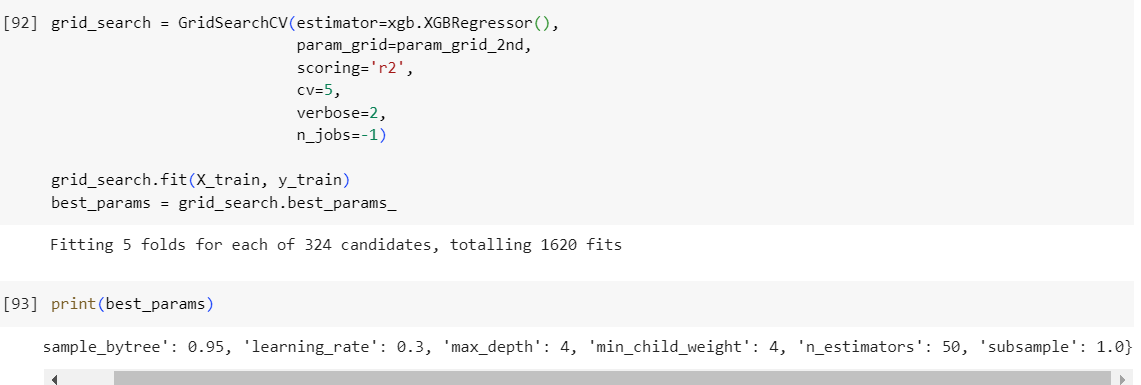

These parameters have been saved in the variable `best_params_2nd`.

In [114]:
best_params_2nd = {'colsample_bytree': 0.95, 'learning_rate': 0.3, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 50, 'subsample': 1.0}

Now, let's use these parameters to fit our model

In [115]:
best_model = xgb.XGBRegressor(**best_params_2nd)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [116]:
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [117]:
print(f'RMSE Score on Test set: {rmse:0.2f}')
print(f'R^2 Score on Test set: {r2:0.2f}')

RMSE Score on Test set: 132.11
R^2 Score on Test set: -2.74


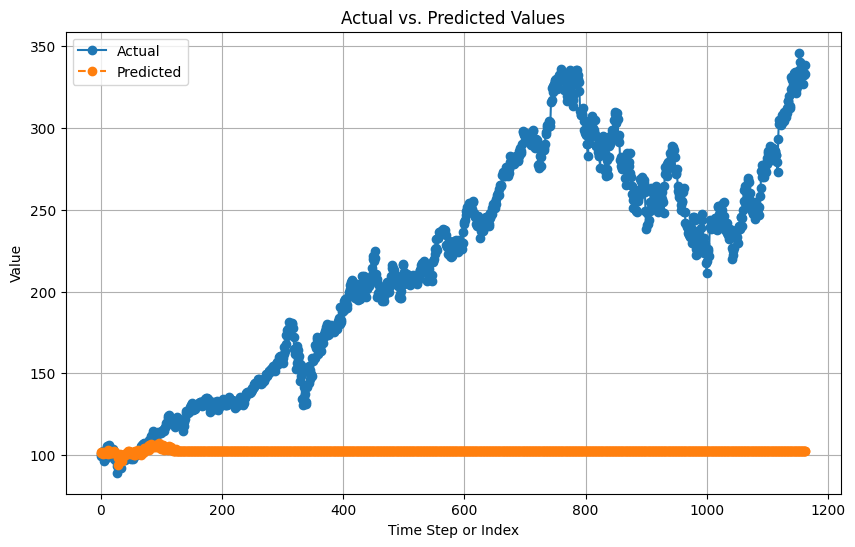

In [118]:
# Create an array for the x-axis (indices or time steps)
x = np.arange(len(y_test))

# Create a line plot for y_pred and y_test
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(x, y_test, label='Actual', marker='o', linestyle='-')
plt.plot(x, y_pred, label='Predicted', marker='o', linestyle='--')

# Add labels and a legend
plt.xlabel('Time Step or Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()

In [119]:
extended_input_sequences.shape

(5820, 91)

# Predict on the scaled dataset

In [120]:
for date in trading_dates:
    # Predict for the next day
    scaled_predictions = model_cv.predict(extended_input_sequences[-1].reshape(1, -1))  # Predict for the last sequence
    print('For each date, we can print the `prediction` array ',scaled_predictions, 'and its shape, ', scaled_predictions.shape)
    # Inverse transform the predictions to get back the original values
    original_predictions = scaler.inverse_transform(scaled_predictions.reshape(-1, 1))

    extended_input_sequences = np.vstack((extended_input_sequences, np.append(extended_input_sequences[-1, 1:], scaled_predictions)))
    extended_output_sequences = np.append(extended_output_sequences, scaled_predictions)

# Print or use the predictions for July 4th to July 10th
print("Predictions for July 10th:", extended_output_sequences[-1])

For each date, we can print the `prediction` array  [138.0360518] and its shape,  (1,)
For each date, we can print the `prediction` array  [163.93692157] and its shape,  (1,)
For each date, we can print the `prediction` array  [172.38471792] and its shape,  (1,)
For each date, we can print the `prediction` array  [171.24295544] and its shape,  (1,)
Predictions for July 10th: 171.24295543722417


# (3) Paramgrid -super optimisation

In [121]:
# Preprocessing
df = df.astype(float)
from sklearn.preprocessing import StandardScaler
# Use StandardScaler to scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)  # Scaling the  data
# Initialize lists to store input and output sequences
input_sequences_scaled = []
output_sequences_scaled = []

# Define the sequence length (12 for input, 13 for output)
sequence_length = 12

# Iterate through the data to create sequences
for i in range(len(df_scaled) - sequence_length - 1): #Iterate through the first 5899 rowss and leave the last 13 rows alone
    input_seq = df_scaled[i:i + sequence_length]  # Get (the rolling) 12 rows from the Price column and add them to a Pandas Series called `input seq`.
    output_seq = df_scaled[i + sequence_length]  # Get the corresponding 13th output value and add it to a Pandas Series called `output_seq`
    input_sequences_scaled.append(list(input_seq))
    output_sequences_scaled.append(output_seq)

# Convert the lists to NumPy arrays
input_sequences_scaled = np.array(input_sequences_scaled)
output_sequences_scaled = np.array(output_sequences_scaled)

# Pick the % of the dataset that we want to set aside for testing
pct_testing = 20

# Convert it into an index location in the input array for slicing
slicing_index = len(input_sequences_scaled) * pct_testing/100  #this makes a float so it needs to be casted onto an `int`
slicing_index = int(slicing_index)


# Slice the input and output sequences to separate training and test data
X_train_cv = input_sequences_scaled[:-slicing_index]
y_train_cv = output_sequences_scaled[:-slicing_index]
X_test_cv = input_sequences_scaled[-slicing_index:]
y_test_cv = output_sequences_scaled[-slicing_index:]
# It needs to be a 2D numpy array for sklearns's MLP Regressor. Therefore, we need to flatten it.
# Flatten X_train
X_train_cv = X_train_cv.reshape((X_train_cv.shape[0], -1))  # Reshape to (4720, 12 * 1)
X_test_cv = X_test_cv.reshape((X_test_cv.shape[0], -1))
# It needs to be a 1D numpy array for sklearns's MLP Regressor. Therefore, we need to flatten it.
# Flatten y_train
y_train_cv = y_train_cv.ravel()
y_test_cv = y_test_cv.ravel()

In [122]:
param_grid = {
    'max_iter': [100, 200, 300, 400, 500, 600],  # Adjust based on convergence and computational resources
    'hidden_layer_sizes': [(50,), (100,), (150,), (200,), (250,)],  # Vary neurons in a single layer
    'activation': ['identity', 'logistic', 'tanh', 'relu'],  # Different activation functions
    'solver': ['lbfgs', 'sgd', 'adam'],  # Various optimization solvers
    'alpha': [0.0001, 0.001, 0.01]  # Regularisation strength
}


In [123]:
# # Comment out after processing
# %%time
# regressor = GridSearchCV(
#     estimator = MLPRegressor(),
#     param_grid = param_grid,
#     n_jobs = 4,
#     error_score='raise'
# )
# regressor.fit(X_train, y_train) #X_train and y_train have been scaled using StandardScaler
# print(regressor.best_score_)
# print(regressor.best_estimator_)

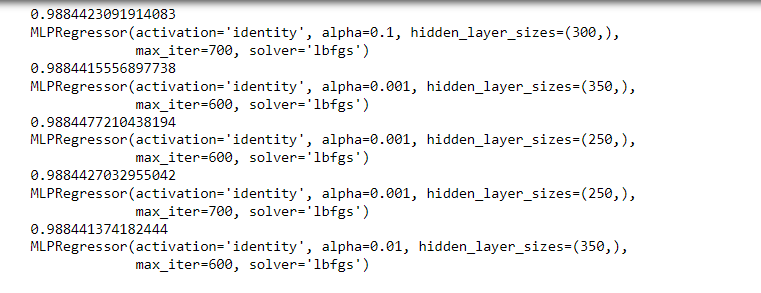

In [124]:
## Set after last cell

best_iter_max = 600
best_layer_size = (350,)
best_activation = 'identity'
best_solver = 'lbfgs'
best_alpha = 0.01

In [125]:
X_train_cv.shape

(4720, 12)

In [126]:
%%time
model_cv = MLPRegressor(hidden_layer_sizes = best_layer_size,
                        max_iter = best_iter_max,
                        activation = best_activation,
                        solver = best_solver,
                        alpha = best_alpha
                        )

model_cv.fit(X_train_cv, y_train_cv)
y_pred_cv = model_cv.predict(X_test_cv)
print(y_pred_cv)
print(y_pred_cv.shape)

[0.46850257 0.46387136 0.46187886 ... 3.29083642 3.34474058 3.35267872]
(1179,)
CPU times: user 265 ms, sys: 186 ms, total: 451 ms
Wall time: 266 ms


In [127]:
# Inverse transform the predictions to get them back to the original scale
y_pred = scaler.inverse_transform(y_pred_cv.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test_cv.reshape(-1, 1))

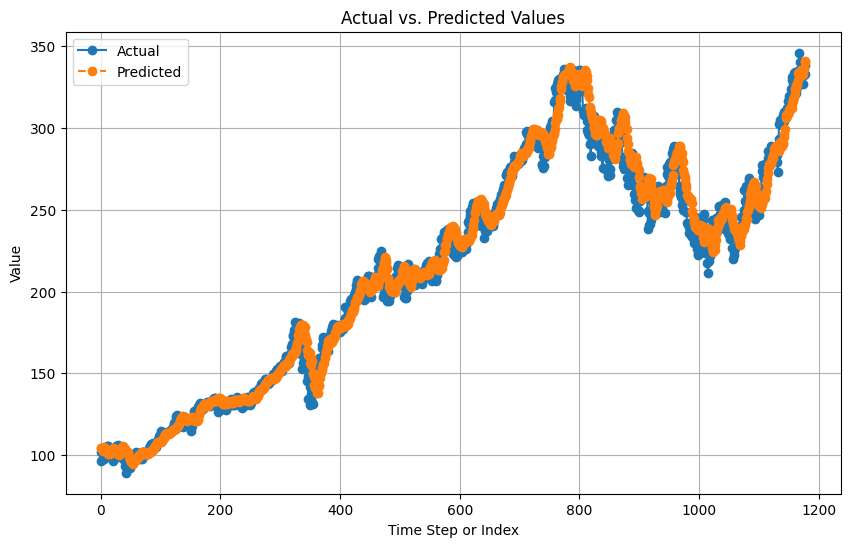

In [128]:
## Evaluate the performance on the Test data
# Create an array for the x-axis (indices or time steps)
x = np.arange(len(y_test))

# Create a line plot for y_pred and y_test
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(x, y_test, label='Actual', marker='o', linestyle='-')
plt.plot(x, y_pred, label='Predicted', marker='o', linestyle='--')

# Add labels and a legend
plt.xlabel('Time Step or Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()


In [129]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"RMSE: {rmse}")
print(f"R-squared (R2) Score: {r2}")

Mean Squared Error (MSE): 97.90325627181046
Mean Absolute Error (MAE): 7.283399063076169
RMSE: 9.894607433941504
R-squared (R2) Score: 0.9794916111966423


In [130]:
# trading_dates = msft[end_date:target_date].index.tz_convert(None).normalize()
# trading_dates = trading_dates[1:] # Exclude the 3rd July 2023 because that's part of the Training Data

# # Extend the sequences up to the 10th of July
# extended_input_sequences = input_sequences.copy()  # Make a copy of the input sequences
# extended_output_sequences = output_sequences.copy()  # Make a copy of the output sequences

# for date in trading_dates:
#     # Predict for the next day
#     scaled_predictions = model_cv.predict(extended_input_sequences[-1].reshape(1, -1))  # Predict for the last sequence
#     print('For each date, we can print the `prediction` array ',scaled_predictions, 'and its shape, ', scaled_predictions.shape)
#     # Inverse transform the predictions to get back the original values
#     original_predictions = scaler.inverse_transform(scaled_predictions.reshape(-1, 1))

#     extended_input_sequences = np.vstack((extended_input_sequences, np.append(extended_input_sequences[-1, 1:], scaled_predictions)))
#     extended_output_sequences = np.append(extended_output_sequences, scaled_predictions)

# # Print or use the predictions for July 4th to July 10th
# print("Predictions for July 10th:", extended_output_sequences[-1])

# # Print or use the predictions for July 4th to July 10th
# print("Predictions for July 10th:", extended_output_sequences[-1])